## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [59]:
!pip install -U gensim
!pip install contractions
!pip install swifter


In [223]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
model = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from nltk import word_tokenize, pos_tag

nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')

import swifter 
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn import naive_bayes # .MultinomialNB
from sklearn.naive_bayes import MultinomialNB

from textblob import TextBlob


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [174]:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [175]:
import contractions

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [176]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
# Opening JSON file 
f = open("/content/drive/MyDrive/ML data /complaintsData/complaints-2021-05-14_08_16.json",'r')  # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.loads(f.read())
df=pd.json_normalize(data)

## Data preparation

In [178]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [179]:
df.shape

(78313, 22)

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [181]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [182]:
#Assign new column names
zip_iterator = zip(list(df.columns), [(x.replace("_","")).replace("source.","") for x in list(df.columns)])
df.rename(columns=dict(zip_iterator), inplace=True)
df.rename(columns={"complaintwhathappened":"complaints"},inplace=True)

# check changes column names
df.columns 

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely', 'complaints',
       'subissue', 'consumerconsentprovided'],
      dtype='object')

In [183]:
df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                     0
subissue                   46297
consumerconsentprovided     1008
dtype: int64

In [184]:
# check columns with blanks  

(df[:] == "").sum() 

index                          0
type                           0
id                             0
score                          0
tags                           0
zipcode                        0
complaintid                    0
issue                          0
datereceived                   0
state                          0
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse          0
subproduct                     0
timely                         0
complaints                 57241
subissue                       0
consumerconsentprovided        0
dtype: int64

In [185]:
#Assign nan in place of blanks in the complaints column

df.replace("", np.nan , inplace=True)

In [186]:
df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                 57241
subissue                   46297
consumerconsentprovided     1008
dtype: int64

In [187]:
# check again  : find % of of na columns wise 

df.isna().sum()/len(df.index)*100

index                       0.000000
type                        0.000000
id                          0.000000
score                       0.000000
tags                       86.081493
zipcode                     8.628197
complaintid                 0.000000
issue                       0.000000
datereceived                0.000000
state                       2.542362
consumerdisputed            0.000000
product                     0.000000
companyresponse             0.000000
company                     0.000000
submittedvia                0.000000
datesenttocompany           0.000000
companypublicresponse      99.994892
subproduct                 13.498397
timely                      0.000000
complaints                 73.092590
subissue                   59.117899
consumerconsentprovided     1.287143
dtype: float64

In [188]:
#Remove all rows where complaints column is nan

df.dropna(inplace = True, subset=["complaints"])

In [189]:
df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       17256
zipcode                     4645
complaintid                    0
issue                          0
datereceived                   0
state                        143
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      21070
subproduct                  2109
timely                         0
complaints                     0
subissue                    8176
consumerconsentprovided        0
dtype: int64

In [190]:
df.shape

(21072, 22)

In [191]:
21072/78313 * 100

26.90741000855541

### 26.9 % of the original data available for further analysis 

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [192]:
## check few complaints before cleaning 

df["complaints"].iloc[1]

'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.'

In [193]:
# Write your function here to clean the text and remove all the unnecessary elements.

def cleanText(text):
  text = text.lower()
  text = re.sub(r'\[|\]',"",text)    # Remove text in square brackets 
  text = re.sub(r'[^\w\s]',"",text)  # Remove punctuation
  text = re.sub(r'\w*\d\w*',"",text) # Remove words containing numbers
  return " ".join(text.split())  # Remove unwanted empty spacs 

df["complaints"] = df["complaints"].swifter.apply(cleanText) 

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [194]:
## check few complaints after cleaning 

df["complaints"].iloc[1]

'i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me'

In [195]:
def check_word_frequency(text):
    return len(str(text).split(' '))

In [196]:
df['word_freq_complaints'] = df['complaints'].apply(check_word_frequency)
df['word_freq_complaints'].describe()

count    21072.000000
mean       243.966211
std        259.961767
min          1.000000
25%         93.000000
50%        175.000000
75%        308.000000
max       5276.000000
Name: word_freq_complaints, dtype: float64

In [224]:
#Write your function to Lemmatize the texts

sw = stopwords.words('english')

lem = WordNetLemmatizer()

# get Lemmatized text 
def lemmatize_text(text):     
    lemmatized = []
    doc = nlp(text)
    for word in doc:
        lemmatized.append(word.lemma_)        
    return " ".join(lemmatized)

# get nouns 
def get_nouns(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

#def lemmatize_text(text):
    #tokens = word_tokenize(text)
    #tokens = list(filter(lambda x:x not in sw , tokens))
    #processed_token = []
    #for w,pos in pos_tag(tokens):
    #    try:
    #        processed_token.append(lem.lemmatize(w,pos[0].lower()))
    #    except:
    #        processed_token.append(lem.lemmatize(w))
    #processed_text = ' '.join(processed_token)
    
#    blob = TextBlob(text)
    
#    return processed_text

In [225]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['lemmatized complaints'] =  df['complaints'].swifter.apply(lemmatize_text)
df['lemmatized complaints'] =  df['lemmatized complaints'].swifter.apply(get_nouns)


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [226]:
df_clean = df[['complaints' , 'lemmatized complaints']].copy()
df_clean.head()

,complaints,lemmatized complaints
1,good morning my name is xxxx xxxx and i apprec...,morning -PRON- name -PRON- stop bank cardmembe...
2,i upgraded my xxxx xxxx card in and was told b...,i card agent upgrade date agent information or...
10,chase card was reported on however fraudulent ...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx ticket i offer ticket card i inf...
14,my grand son give me check for i deposit it in...,son check deposit -PRON- chase account fund ch...


In [228]:
#Write your function to extract the POS tags 

def extract_POS_tags(text):
  nouns =  [token for token, pos in pos_tag(word_tokenize(text)) if pos.startswith('N')]
  return ' '.join(nouns)

In [229]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] =  df['lemmatized complaints'].swifter.apply(extract_POS_tags)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [230]:
df_clean.head()

,complaints,lemmatized complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,morning -PRON- name -PRON- stop bank cardmembe...,morning -PRON- name -PRON- bank cardmember ser...
2,i upgraded my xxxx xxxx card in and was told b...,i card agent upgrade date agent information or...,card agent date agent information order accoun...
10,chase card was reported on however fraudulent ...,card report application identity consent servi...,report application identity consent service cr...
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx ticket i offer ticket card i inf...,book ticket i ticket card i information minute...
14,my grand son give me check for i deposit it in...,son check deposit -PRON- chase account fund ch...,son deposit chase account fund bank account mo...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




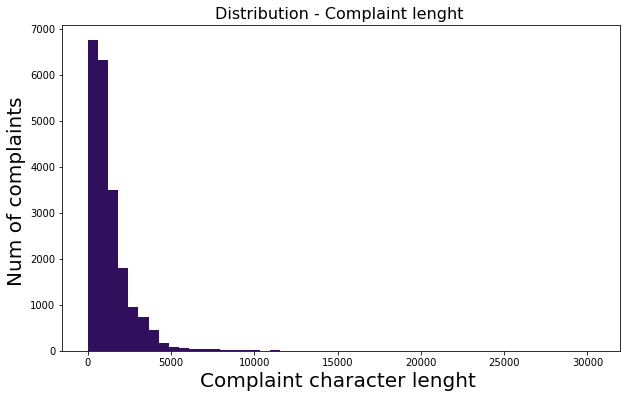

In [231]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean["complaint_length"] = df_clean["complaints"].apply(len)

fig = plt.figure(figsize=(10,6))

plt.hist(df_clean['complaint_length'],bins=50,color='#30105C')

plt.title('Distribution - Complaint lenght ', fontsize=16)
plt.ylabel('Num of complaints ', fontsize=20)
plt.xlabel('Complaint character lenght ', fontsize=20)

plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

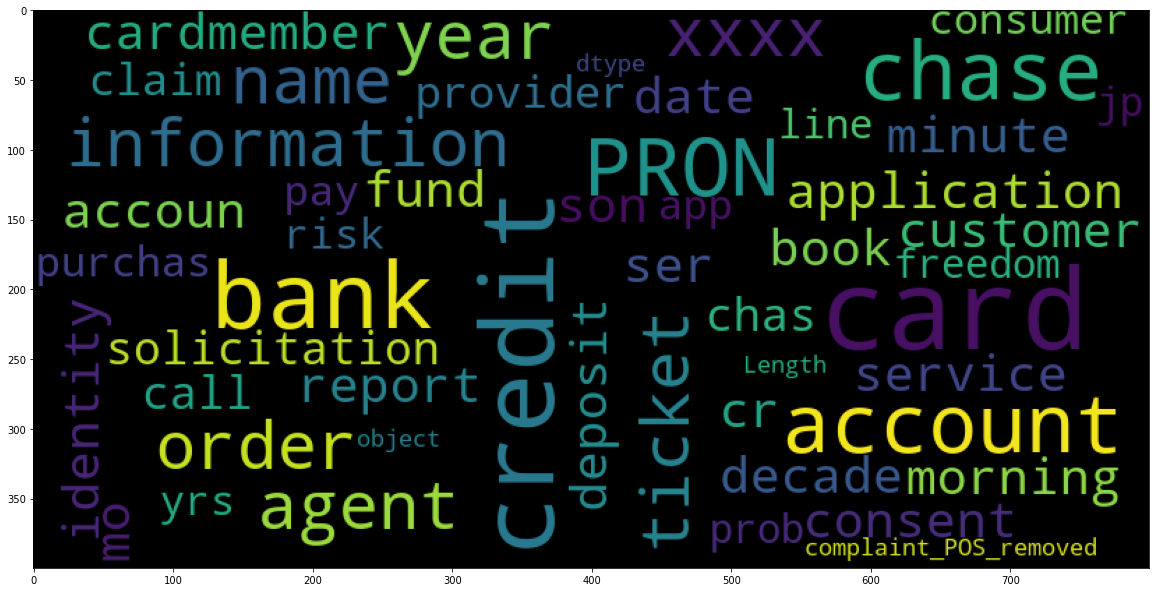

In [232]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400, stopwords = stopwords,
                      colormap = 'viridis', max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)

In [233]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')


In [234]:
df_clean

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,morning -PRON- name -PRON- stop bank cardmembe...,morning -PRON- name -PRON- bank cardmember ser...,469,morning name bank cardmember service debt ve...
2,i upgraded my xxxx xxxx card in and was told b...,i card agent upgrade date agent information or...,card agent date agent information order accoun...,334,card agent date agent information order accoun...
10,chase card was reported on however fraudulent ...,card report application identity consent servi...,report application identity consent service cr...,209,report application identity consent service cr...
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx ticket i offer ticket card i inf...,book ticket i ticket card i information minute...,1424,book ticket i ticket card i information minute...
14,my grand son give me check for i deposit it in...,son check deposit -PRON- chase account fund ch...,son deposit chase account fund bank account mo...,452,son deposit chase account fund bank account mo...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,639,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,i call chas -PRON- credit card provider claim ...,i call chas credit card provider claim purchas...,2055,i call chas credit card provider claim purchas...
78310,i am not familiar with xxxx pay and did not un...,pay risk provide consumer i -PRON- bank app ch...,pay risk consumer i -PRON- bank app chase year...,2294,pay risk consumer i bank app chase year trust...
78311,i have had flawless credit for yrs ive had cha...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom xxxx prob...,1961,credit yrs credit card chase freedom xxxx prob...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [235]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_unigrams(text, n=None):
    vec = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [236]:
#Print the top 10 words in the unigram frequency
common_words = get_top_unigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
unigram.head(10)

,unigram,count
0,account,40016
1,credit,34154
2,chase,34095
3,bank,28401
4,xxxx,26786
5,card,25188
6,payment,21159
7,time,16005
8,charge,14841
9,day,12971


In [237]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_bigrams(text, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [238]:
#Print the top 10 words in the bigram frequency
common_words = get_top_bigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
bigram.head(10)

,bigram,count
0,credit card,12493
1,credit report,4019
2,customer service,3080
3,xxxx xxxx,2747
4,bank account,2603
5,chase credit,2448
6,account account,2045
7,chase account,2032
8,account bank,1770
9,payment payment,1731


In [239]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigrams(text, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [240]:
#Print the top 10 words in the trigram frequency
common_words = get_top_trigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
trigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
trigram.head(10)

,bigram,count
0,chase credit card,1637
1,credit card company,1010
2,credit card account,881
3,credit card credit,601
4,credit card chase,519
5,credit report credit,475
6,charge credit card,471
7,card credit card,429
8,credit card bank,422
9,account credit card,411


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [241]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

def remove_allXX(text):
  return re.sub('[x]{2,}',"",text)

df_clean['Complaint_clean'] = df_clean['Complaint_clean'].apply(remove_allXX)


In [242]:
#All masked texts has been removed
df_clean

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,morning -PRON- name -PRON- stop bank cardmembe...,morning -PRON- name -PRON- bank cardmember ser...,469,morning name bank cardmember service debt ve...
2,i upgraded my xxxx xxxx card in and was told b...,i card agent upgrade date agent information or...,card agent date agent information order accoun...,334,card agent date agent information order accoun...
10,chase card was reported on however fraudulent ...,card report application identity consent servi...,report application identity consent service cr...,209,report application identity consent service cr...
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx ticket i offer ticket card i inf...,book ticket i ticket card i information minute...,1424,book ticket i ticket card i information minute...
14,my grand son give me check for i deposit it in...,son check deposit -PRON- chase account fund ch...,son deposit chase account fund bank account mo...,452,son deposit chase account fund bank account mo...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,639,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,i call chas -PRON- credit card provider claim ...,i call chas credit card provider claim purchas...,2055,i call chas credit card provider claim purchas...
78310,i am not familiar with xxxx pay and did not un...,pay risk provide consumer i -PRON- bank app ch...,pay risk consumer i -PRON- bank app chase year...,2294,pay risk consumer i bank app chase year trust...
78311,i have had flawless credit for yrs ive had cha...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom xxxx prob...,1961,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [243]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [244]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [245]:
from sklearn.decomposition import NMF

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['Complaint_clean']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:195: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:317: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:195: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:317: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:195: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:317: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-p

5


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [246]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=5, random_state=40) #write your code here

In [247]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

5937

In [248]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['fraud', 'customer', 'claim', 'business', 'number', 'transaction', 'branch', 'day', 'chase', 'deposit', 'fund', 'check', 'money', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'application', 'letter', 'limit', 'debt', 'information', 'score', 'company', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['car', 'account', 'year', 'mortgage', 'credit', 'date', 'pay', 'auto', 'time', 'day', 'fee', 'statement', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['company', 'balance', 'time', 'statement', 'service', 'claim', 'fraud', 'merchant', 'chase', 'purchase', 'dispute', 'card', 'transaction', 'fee', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['bank', 'foreclosure', 'document', 'sale', 'house', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [249]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)


array([0, 1, 1, ..., 3, 2, 2])

In [250]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [251]:
df_clean.head()

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning -PRON- name -PRON- stop bank cardmembe...,morning -PRON- name -PRON- bank cardmember ser...,469,morning name bank cardmember service debt ve...,0
2,i upgraded my xxxx xxxx card in and was told b...,i card agent upgrade date agent information or...,card agent date agent information order accoun...,334,card agent date agent information order accoun...,1
10,chase card was reported on however fraudulent ...,card report application identity consent servi...,report application identity consent service cr...,209,report application identity consent service cr...,1
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx ticket i offer ticket card i inf...,book ticket i ticket card i information minute...,1424,book ticket i ticket card i information minute...,1
14,my grand son give me check for i deposit it in...,son check deposit -PRON- chase account fund ch...,son deposit chase account fund bank account mo...,452,son deposit chase account fund bank account mo...,0


In [252]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning -PRON- name -PRON- stop bank cardmembe...,morning -PRON- name -PRON- bank cardmember ser...,469,morning name bank cardmember service debt ve...,0
14,my grand son give me check for i deposit it in...,son check deposit -PRON- chase account fund ch...,son deposit chase account fund bank account mo...,452,son deposit chase account fund bank account mo...,0
17,with out notice jp morgan chase restricted my ...,jp restrict account debit card tuesday thursda...,jp restrict account debit card tuesday thursda...,2221,jp restrict account debit card tuesday thursda...,0
24,mishandling of this account by chase auto and ...,mishandle account auto xxxx,mishandle account auto xxxx,50,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,i account bank code bonus i term everything ac...,i bank code term everything account deposit bo...,401,i bank code term everything account deposit bo...,0
2,i upgraded my xxxx xxxx card in and was told b...,i card agent upgrade date agent information or...,card agent date agent information order accoun...,334,card agent date agent information order accoun...,1
10,chase card was reported on however fraudulent ...,card report application identity consent servi...,report application identity consent service cr...,209,report application identity consent service cr...,1
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx ticket i offer ticket card i inf...,book ticket i ticket card i information minute...,1424,book ticket i ticket card i information minute...,1
15,can you please remove inquiry,inquiry,inquiry,29,inquiry,1
23,i have a chase credit card which is incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,127,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [253]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [254]:
df_clean

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning -PRON- name -PRON- stop bank cardmembe...,morning -PRON- name -PRON- bank cardmember ser...,469,morning name bank cardmember service debt ve...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told b...,i card agent upgrade date agent information or...,card agent date agent information order accoun...,334,card agent date agent information order accoun...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,card report application identity consent servi...,report application identity consent service cr...,209,report application identity consent service cr...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx ticket i offer ticket card i inf...,book ticket i ticket card i information minute...,1424,book ticket i ticket card i information minute...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,son check deposit -PRON- chase account fund ch...,son deposit chase account fund bank account mo...,452,son deposit chase account fund bank account mo...,Bank Account services
15,can you please remove inquiry,inquiry,inquiry,29,inquiry,Credit card or prepaid card
17,with out notice jp morgan chase restricted my ...,jp restrict account debit card tuesday thursda...,jp restrict account debit card tuesday thursda...,2221,jp restrict account debit card tuesday thursda...,Bank Account services
20,during the summer months i experience a declin...,summer month i income employment therefore i m...,summer month income employment month payment e...,1342,summer month income employment month payment e...,Others
21,on xxxx i made a payment to an online retailer...,xxxx payment online retailer use pay xxxx chas...,payment online retailer use pay xxxx chase web...,3444,payment online retailer use pay chase website...,Theft/Dispute Reporting
23,i have a chase credit card which is incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,127,chase credit card datum credit report company ...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [255]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [256]:
df_clean

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning -PRON- name -PRON- stop bank cardmembe...,morning -PRON- name -PRON- bank cardmember ser...,469,morning name bank cardmember service debt ve...,0
2,i upgraded my xxxx xxxx card in and was told b...,i card agent upgrade date agent information or...,card agent date agent information order accoun...,334,card agent date agent information order accoun...,1
10,chase card was reported on however fraudulent ...,card report application identity consent servi...,report application identity consent service cr...,209,report application identity consent service cr...,1
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx ticket i offer ticket card i inf...,book ticket i ticket card i information minute...,1424,book ticket i ticket card i information minute...,1
14,my grand son give me check for i deposit it in...,son check deposit -PRON- chase account fund ch...,son deposit chase account fund bank account mo...,452,son deposit chase account fund bank account mo...,0
15,can you please remove inquiry,inquiry,inquiry,29,inquiry,1
17,with out notice jp morgan chase restricted my ...,jp restrict account debit card tuesday thursda...,jp restrict account debit card tuesday thursda...,2221,jp restrict account debit card tuesday thursda...,0
20,during the summer months i experience a declin...,summer month i income employment therefore i m...,summer month income employment month payment e...,1342,summer month income employment month payment e...,2
21,on xxxx i made a payment to an online retailer...,xxxx payment online retailer use pay xxxx chas...,payment online retailer use pay xxxx chase web...,3444,payment online retailer use pay chase website...,3
23,i have a chase credit card which is incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,127,chase credit card datum credit report company ...,1


In [257]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[["complaints","Topic"]]

In [258]:
training_data

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told b...,1
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a xxxx xxxx ticket i c...,1
14,my grand son give me check for i deposit it in...,0
15,can you please remove inquiry,1
17,with out notice jp morgan chase restricted my ...,0
20,during the summer months i experience a declin...,2
21,on xxxx i made a payment to an online retailer...,3
23,i have a chase credit card which is incorrectl...,1


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [259]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaints'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [260]:
# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (18, 940)
Shape of y_train: (18,)
Shape of X_test: (7, 940)
Shape of y_test: (7,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [261]:
# Write your code here to build any 3 models and evaluate them using the required metrics




In [287]:
# Create a function to evaluate models
def eval_model(y_test, y_pred, model_name):
  
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    
    return

In [288]:
# Logistic regression
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

In [289]:
# Calculate F1 Score of tuned model 
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.2952380952380952

In [290]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga') 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

In [291]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.03571428571428571

In [292]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_lr_tuned, model_name)

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00         2
Credit card or prepaid card       0.00      0.00      0.00         1
                     Others       0.00      0.00      0.00         1
    Theft/Dispute Reporting       0.00      0.00      0.00         2
              Mortgage/Loan       0.14      1.00      0.25         1

                   accuracy                           0.14         7
                  macro avg       0.03      0.20      0.05         7
               weighted avg       0.02      0.14      0.04         7



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [293]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score (untuned)': round(f1_lr, 2), 'F1 Score (tuned)': round(f1_lr_tuned, 2)}])
summary



,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.3,0.04


In [294]:
# Decision Tree 

# Run Decision Tree on default hyperparameters
model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

In [295]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.23809523809523808

In [296]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=30, 
                                      min_samples_leaf=15, 
                                      max_features=None)

clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

In [297]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned

0.03571428571428571

In [298]:
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_dt_tuned, model_name)

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00         2
Credit card or prepaid card       0.14      1.00      0.25         1
                     Others       0.00      0.00      0.00         1
    Theft/Dispute Reporting       0.00      0.00      0.00         2
              Mortgage/Loan       0.00      0.00      0.00         1

                   accuracy                           0.14         7
                  macro avg       0.03      0.20      0.05         7
               weighted avg       0.02      0.14      0.04         7



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [299]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.30,0.04
1,Decision Tree,0.24,0.04


In [300]:
# Random Forest 
# Run the Random Forest model on default hyperparameters
model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

In [301]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.4047619047619047

In [302]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, 
                                      min_samples_split=5, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=30, 
                                      criterion='gini'
)

clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

In [303]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.19999999999999998

In [304]:
# Evaluate the tuned Random Forest classifier
eval_model(y_test, y_pred_rf_tuned, model_name)

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00         2
Credit card or prepaid card       1.00      1.00      1.00         1
                     Others       0.25      1.00      0.40         1
    Theft/Dispute Reporting       0.00      0.00      0.00         2
              Mortgage/Loan       0.00      0.00      0.00         1

                   accuracy                           0.29         7
                  macro avg       0.25      0.40      0.28         7
               weighted avg       0.18      0.29      0.20         7



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [305]:
# Update the summary table
summary.loc[len(summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.30,0.04
1,Decision Tree,0.24,0.04
2,Random Forest,0.40,0.20


In [306]:
# Naive Baiyes  ( Optional)

model_name = 'NAIVE BAYES'
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

In [307]:
# Calculate F1 Score using weighted average method
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.2952380952380952

In [308]:
# Run Multinomial Naive Bayes on tuned hyperparameters
clf_nb_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
clf_nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = clf_nb_tuned.predict(X_test)

In [309]:
# Calculate F1 Score of tuned model using weighted average method
f1_nb_tuned = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb_tuned

0.14285714285714285

In [310]:
# Evaluate the tuned Naive Bayes classifier
eval_model(y_test, y_pred_nb_tuned, model_name)

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00         2
Credit card or prepaid card       0.33      1.00      0.50         1
                     Others       0.33      1.00      0.50         1
    Theft/Dispute Reporting       0.00      0.00      0.00         2
              Mortgage/Loan       0.00      0.00      0.00         1

                   accuracy                           0.29         7
                  macro avg       0.13      0.40      0.20         7
               weighted avg       0.10      0.29      0.14         7



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [311]:
# Update the summary table
summary.loc[len(summary.index)] = ['Naive Bayes', round(f1_nb, 2), round(f1_nb_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.30,0.04
1,Decision Tree,0.24,0.04
2,Random Forest,0.40,0.20
3,Naive Bayes,0.30,0.14


## The best model is Random forest  with 0.4 untuned F1 score 